In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import dendrogram, linkage





In [2]:
df = pd.read_csv('marketing_campaign.csv', delimiter='\t')
df.head(10)


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0
5,7446,1967,Master,Together,62513.0,0,1,09-09-2013,16,520,...,6,0,0,0,0,0,0,3,11,0
6,965,1971,Graduation,Divorced,55635.0,0,1,13-11-2012,34,235,...,6,0,0,0,0,0,0,3,11,0
7,6177,1985,PhD,Married,33454.0,1,0,08-05-2013,32,76,...,8,0,0,0,0,0,0,3,11,0
8,4855,1974,PhD,Together,30351.0,1,0,06-06-2013,19,14,...,9,0,0,0,0,0,0,3,11,1
9,5899,1950,PhD,Together,5648.0,1,1,13-03-2014,68,28,...,20,1,0,0,0,0,0,3,11,0


### 1. Preprocessing

In [3]:
def fill_nan(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Fills empty values 
    '''
    for col in df.columns:
        if df[col].dtype in ['float64', 'int64']:  # Apply median to numeric columns
            df[col] = df[col].fillna(df[col].median())
        elif df[col].dtype == 'object':  # Apply mode to categorical columns
            df[col] = df[col].fillna(df[col].mode().iloc[0])
    return df

def encode_cat(df: pd.DataFrame, col: str) -> pd.DataFrame:
    '''
    Encodes categorical values into numeric values
    '''
    val_map = {}
    code = 0
    for value in df[col].unique():
        if value not in val_map:
            val_map[value] = code
            code += 1
    df[col] = df[col].map(val_map)
    return df

def clean(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Performs all cleaning operations on df
    '''
    df = df.drop('ID', axis=1)
    df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format = '%d-%m-%Y')

    fill_nan(df)
    categorical_cols = ['Education', 'Marital_Status', 'Dt_Customer']

    for col in categorical_cols:
        df = encode_cat(df, col)
    return df
df = clean(df)


Preprocessing:
 - filled empty values (median for numeric values, mode for categorical values)
 - label encoded categorical values
 - dropped ID column because it's patternless
 - converted date column to date-time value 

### 2. K-Means

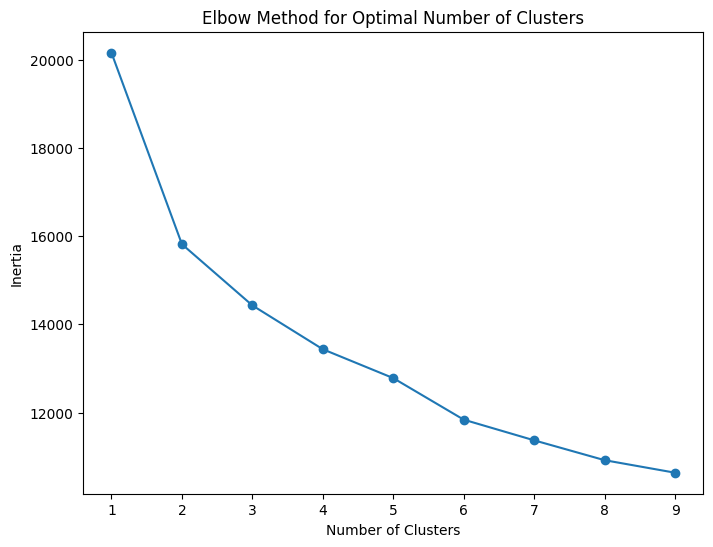

In [4]:
def kmeans(df: pd.DataFrame):
    sc = StandardScaler()
    features = ['Year_Birth', 'Education', 'Marital_Status', 'Income', 
                'NumWebPurchases', 'NumStorePurchases', 'Kidhome', 'Teenhome', 'Recency']
    X = df[features]
    X = sc.fit_transform(X)
    inertia = []

    for k in range(1, 10):
        model = KMeans(n_clusters=k, random_state=42).fit(X)
        inertia.append(model.inertia_)
    return inertia

def elbow(df: pd.DataFrame):
    inertia = kmeans(df)

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, 10), inertia, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.show()
elbow(df)

In this case, using all of the data will add unnecessary complexity and noise. Using the most important characteristics of a customer (age, income, children, number of purchases, etc) will give us a better idea of how to categorize them. Using the elbow plot above, the ideal number of clusters will be 2 or 3.

### 3. Hierarchical Clustering

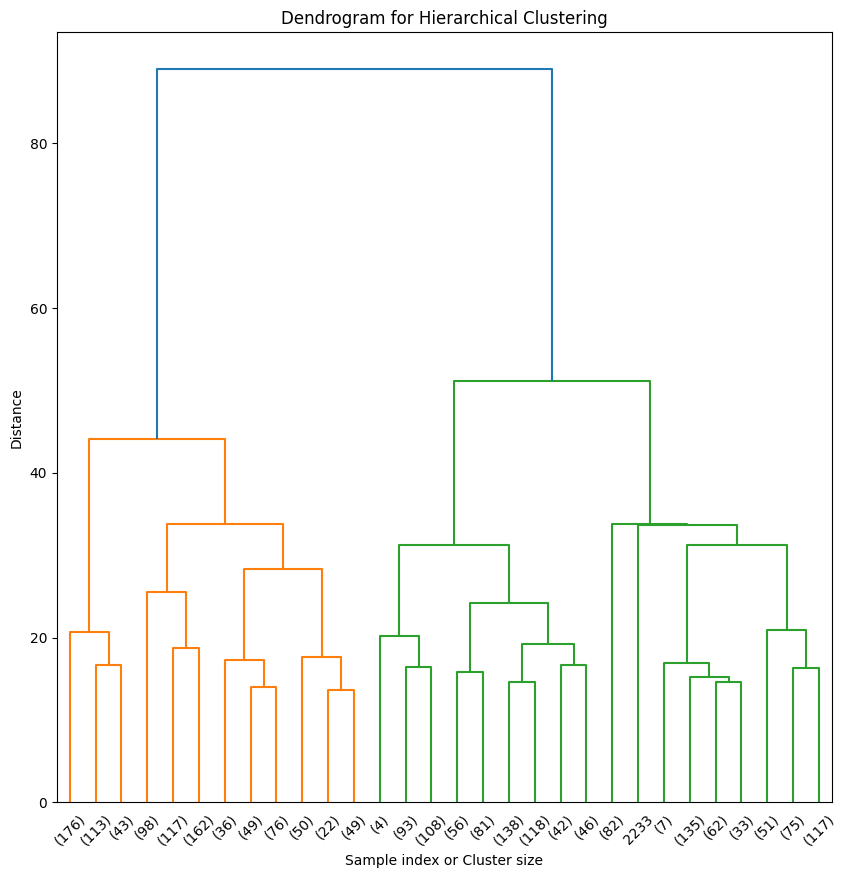

In [5]:
def dendro(df: pd.DataFrame):
    sc = StandardScaler()
    features = ['Year_Birth', 'Education', 'Marital_Status', 'Income', 
                'NumWebPurchases', 'NumStorePurchases', 'Kidhome', 'Teenhome']
    X = df[features]
    X = sc.fit_transform(X)
    linked = linkage(X, method='ward')

    plt.figure(figsize=(10, 10))
    dendrogram(linked, truncate_mode='lastp', p=30)
    plt.xlabel("Sample index or Cluster size")
    plt.ylabel("Distance")
    plt.title("Dendrogram for Hierarchical Clustering")
    plt.show()
    
dendro(df)

The dendrogram above shows 2 or 3 distinct clusters but i think that you could arguably say there is 4, since both the orange and green clusters are very close to being completely split. I would personally say there is 4 clusters.  

### 4. Comparing Results

i think that Hierarchical Clustering gives us a better representation of how the data should be clustered. In contrast to the Elbow plot, the Dendrogram allows room for us to use our intuition, which can be important in cases where the line between clusters is harder to pinpoint.